In [1]:
import argparse # Terminal arguments
import os
import sys      # System access
import time     # Timing
import resource # Memory usage

# Python3 at least
assert sys.version_info >= (3, 0)

import numpy as np
import sysconfig as sc

ang2bohr   = 1.88972612546
ev2hartree = 0.03674930814

# Own includes
import atomistic_tools.cp2k_grid_orbitals as cgo
import atomistic_tools.cp2k_stm_sts as css
from atomistic_tools import common
from atomistic_tools.cube import Cube

import hrstm_tools.ppstm_grid_orbitals as pgo

import hrstm_tools.tip_coeffs as tc
import hrstm_tools.cp2k_grid_matrix as cgm
import hrstm_tools.hrstm_utils as hu
import hrstm_tools.hrstm as hs

class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
args = Namespace()
args.cp2k_input_file = "examples/Samples/TOAT/sample.inp"
args.basis_set_file = "examples/Samples/BASIS_MOLOPT"
args.xyz_file = "examples/Samples/TOAT/sample.xyz"
args.wfn_file = "examples/Samples/TOAT/SAMPLE-RESTART.wfn"
args.tip_pos_files = ["examples/Samples/TOAT/Qo-0.12Qc0.07K0.11/PPpos",
        "examples/Samples/TOAT/Qo-0.12Qc0.07K0.11/PPdisp"]
args.pdos_list = ["tips/blunt/aiida-PDOS-list2-1.pdos",
        "tips/blunt/aiida-PDOS-list1-1.pdos"]
args.tip_shift = -3.0
args.orbs_tip = 1
args.voltages = [-1.0, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
args.hartree_file = "examples/Samples/TOAT/SAMPLE-HART-v_hartree-1_0.cube"
args.fwhm_sam = 0.05
args.fwhm_tip = 0.01
args.extrap_dist = 5.0
args.dx_wfn = 0.2
args.emax = 2.0
args.emin = -2.0
args.orbs_tip = 1
# Note: Default 14.0 to short!
args.rcut = 30.0
args.rotate = True

In [2]:
### ----------------------------------------------------------------------------
### Read tip positions on ranks
### ----------------------------------------------------------------------------

start = time.time()
tip_pos, tip_grid_dim_all, sam_eval_region, lVec = hu.read_tip_positions( \
    args.tip_pos_files, args.tip_shift, args.dx_wfn)
end = time.time()
print("Reading tip positions in {} seconds.".format(end-start))

Reading tip positions in 0.365786075592041 seconds.


In [3]:
### ----------------------------------------------------------------------------
### Setup tip coefficients
### ----------------------------------------------------------------------------

start = time.time()
tip_coeffs = tc.TipCoefficients()
tip_coeffs.read_coefficients(args.orbs_tip, args.pdos_list, 
                             min(args.voltages)-4*args.fwhm_tip, 
                             max(args.voltages)+4*args.fwhm_tip)
tip_coeffs.initialize(tip_pos, args.rotate)
end = time.time()
print("Reading tip coefficients in {} seconds.".format(end-start))

Rotational matrices took 0.713472843170166 seconds
Reading tip coefficients in 1.7481038570404053 seconds.


In [4]:
### ----------------------------------------------------------------------------
###  Evaluate sample orbitals
### ----------------------------------------------------------------------------

start = time.time()
#sam_grid_orb = cgo.Cp2kGridOrbitals(single_precision=False)
sam_grid_orb = pgo.PPSTMGridOrbitals(single_precision=False)
sam_grid_orb.read_cp2k_input(args.cp2k_input_file)
sam_grid_orb.read_xyz(args.xyz_file)
sam_grid_orb.read_basis_functions(args.basis_set_file)
sam_grid_orb.load_restart_wfn_file(args.wfn_file,
    emin=args.emin-4.0*args.fwhm_sam, emax=args.emax+4.0*args.fwhm_sam)
sam_grid_orb.calc_morbs_in_region(args.dx_wfn,
    #x_eval_region=sam_eval_region[0]*ang2bohr,
    #y_eval_region=sam_eval_region[1]*ang2bohr,
    z_eval_region=sam_eval_region[2]*ang2bohr,
    reserve_extrap = args.extrap_dist,
    eval_cutoff = args.rcut)
end = time.time()
print("Building CP2K wave function matrix in {} seconds.".format( \
  end-start))

R0/1, loading indexes 49:57 / 49:57
Global cell:  [ 75  75 100]
Eval cell:  [75 75 20]
local cell:  [150 150  20]
---- Setup: 0.0030
---- Radial calc time : 2.380165
---- Spherical calc time : 1.456953
---- Loc -> loc_morb time : 10.471571
---- loc_morb -> glob time : 0.359057
---- Total time: 15.2583
Building CP2K wave function matrix in 15.294224262237549 seconds.


In [5]:
### ----------------------------------------------------------------------------
### Extrapolate orbitals
### ----------------------------------------------------------------------------

start = time.time()
hart_cube = Cube()
hart_cube.read_cube_file(args.hartree_file)
extrap_plane_z = sam_eval_region[2][1] \
    - np.max(sam_grid_orb.ase_atoms.positions[:,2])
hart_plane = hart_cube.get_plane_above_topmost_atom(extrap_plane_z) \
  - sam_grid_orb.ref_energy*ev2hartree
#del hart_cube, extrap_plane_z
sam_grid_orb.extrapolate_morbs(hart_plane=hart_plane)
end = time.time()
print("Extrapolating CP2K wave function matrix in {} seconds."\
  .format(end-start))

Extrapolating CP2K wave function matrix in 0.13153767585754395 seconds.


In [6]:
### ----------------------------------------------------------------------------
### Divide grid orbitals along space and put in wrapper
### ----------------------------------------------------------------------------

start = time.time()
sam_grid_matrix = cgm.Cp2kGridMatrix(sam_grid_orb, sam_eval_region, tip_pos[1:],
    args.orbs_tip)
sam_grid_matrix.divide()
#del sam_grid_orb #, tip_pos
end = time.time()
print("Setting up wave function object in {} seconds."\
    .format(end-start))

Setting up wave function object in 0.025315284729003906 seconds.


In [7]:
### ----------------------------------------------------------------------------
### Evaluate HRSTM and write output
### ----------------------------------------------------------------------------

start = time.time()
hrstm = hs.Hrstm(tip_coeffs, tip_grid_dim_all, sam_grid_matrix, args.fwhm_sam, args.fwhm_tip)
hrstm.run(args.voltages)
current = hrstm.gather()
end = time.time()
print("Evaluating HRSTM-run method in {} seconds.".format(end-start))

Total time for tunneling matrix was 31.536514043807983 seconds.
Total time for voltage loop was 3.010802984237671 seconds.
Evaluating HRSTM-run method in 34.59398603439331 seconds.


In [8]:
### ----------------------------------------------------------------------------
### ----------------------------------------------------------------------------
### ----------------------------------------------------------------------------
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [50,10]
fig, axes = plt.subplots(1,len(args.voltages))
for idx in range(len(args.voltages)):
    axes[idx].imshow(abs(current[:,:,3,idx]).T, cmap="gist_gray")
    axes[idx].axis("off")
plt.tight_layout()
plt.show()

<Figure size 5000x1000 with 11 Axes>

0.0


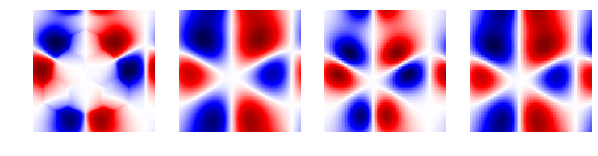

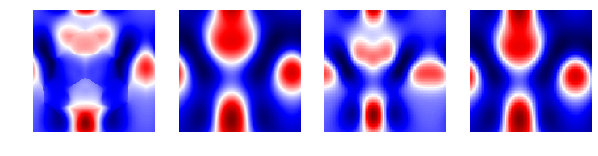

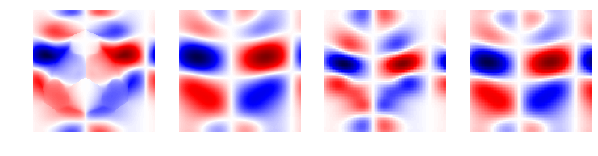

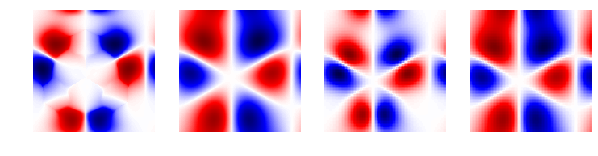

In [11]:
plt.rcParams['figure.figsize'] = [10, 10]
eIdx = 8
print(sam_grid_matrix.ene[0][eIdx])
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow((sam_grid_matrix[1,0,eIdx][0,:,:,2]).T, cmap="seismic", origin='lower')
ax2.imshow((sam_grid_matrix[0,0,eIdx][0,:,:,-1]).T, cmap="seismic", origin='lower')
ax3.imshow((sam_grid_matrix._wfn_matrix[0][eIdx][:,:,2]).T, cmap="seismic", origin='lower')
ax4.imshow((sam_grid_matrix._wfn_matrix[0][eIdx][:,:,-1]).T, cmap="seismic", origin='lower')
ax1.axis("off"); ax2.axis("off"); ax3.axis("off"); ax4.axis("off") 
plt.show()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow((sam_grid_matrix[1,0,eIdx][3,:,:,2]).T, cmap="seismic", origin='lower')
ax2.imshow((sam_grid_matrix[0,0,eIdx][3,:,:,-1]).T, cmap="seismic", origin='lower')
ax3.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=0)[:,:,2]).T, cmap="seismic", origin='lower')
ax4.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=0)[:,:,-1]).T, cmap="seismic", origin='lower')
ax1.axis("off"); ax2.axis("off"); ax3.axis("off"); ax4.axis("off") 
plt.show()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow((sam_grid_matrix[1,0,eIdx][1,:,:,2]).T, cmap="seismic", origin='lower')
ax2.imshow((sam_grid_matrix[0,0,eIdx][1,:,:,-1]).T, cmap="seismic", origin='lower')
ax3.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=1)[:,:,2]).T, cmap="seismic", origin='lower')
ax4.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=1)[:,:,-1]).T, cmap="seismic", origin='lower')
ax1.axis("off"); ax2.axis("off"); ax3.axis("off"); ax4.axis("off") 
plt.show()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
ax1.imshow((sam_grid_matrix[1,0,eIdx][2,:,:,2]).T, cmap="seismic", origin='lower')
ax2.imshow((sam_grid_matrix[0,0,eIdx][2,:,:,-1]).T, cmap="seismic", origin='lower')
ax3.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=2)[:,:,2]).T, cmap="seismic", origin='lower')
ax4.imshow((np.gradient(sam_grid_matrix._wfn_matrix[0][eIdx], edge_order=2, axis=2)[:,:,-1]).T, cmap="seismic", origin='lower')
ax1.axis("off"); ax2.axis("off"); ax3.axis("off"); ax4.axis("off") 
plt.show()